# Arxiv Data Exploration

In [88]:
import requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly import io as pio
from upsetplot import UpSet, from_contents, from_memberships
from upsetplot import plot as ups_plot
import json
from IPython.display import display
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

from bs4 import BeautifulSoup

# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
def save_and_show(fig, name):
    with open(f"./graphs/{name}.json", "w") as f:
        f.write(pio.to_json(fig))
    fig.show()

## Load Data

In [2]:
arxiv_metadata = pd.read_json('./arxiv-metadata-oai-snapshot.json', lines=True)

In [28]:
print(f"Number of rows: {len(arxiv_metadata)}")
arxiv_metadata.head()

Number of rows: 2511805


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,year,main_categories,is_cs
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",2008,[Physics],False
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2008,"[Computer Science, Mathematics]",True
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]",2008,[Physics],False
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]",2007,[Mathematics],False
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2013,[Mathematics],False


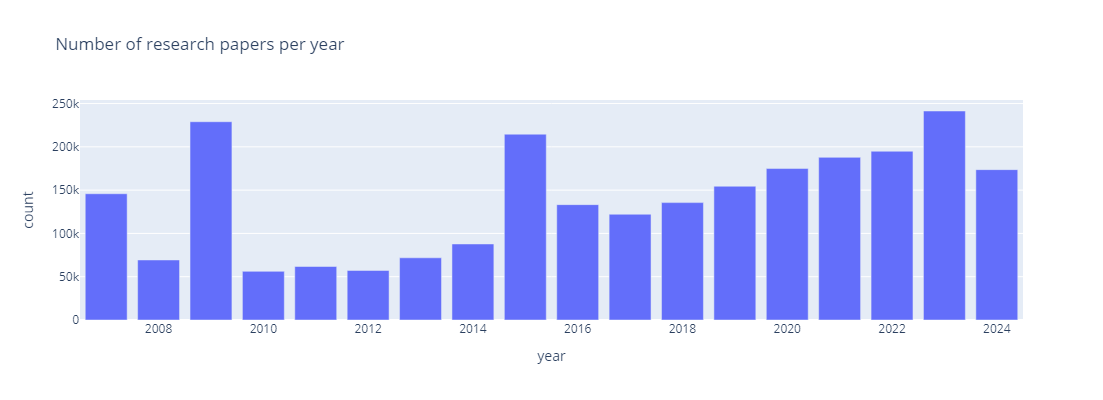

In [98]:
# Show number of papers by year, let's use `update_date` for the year info
arxiv_metadata['update_date'] = pd.to_datetime(arxiv_metadata['update_date'])
arxiv_metadata['year'] = arxiv_metadata['update_date'].dt.year

year_counts = arxiv_metadata['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

fig = px.bar(year_counts, x='year', y='count', title='Number of research papers per year')

fig.update_layout(
    width=550,
    height=400,
)

save_and_show(fig, "research_per_year")

## Categories

Categories in the data is actually in abreviations defined on: [ArXiv Category Taxonomy](https://arxiv.org/category_taxonomy). We'll extract those and create a expanded categories for each catgory abbreviation given. In general, a category is defined as: `<Main Category>.<Sub-Category>`.

In [99]:
# Categories are defined on this page by Arxiv: https://arxiv.org/category_taxonomy
url = "https://arxiv.org/category_taxonomy"

# Send a GET request to the URL
response = requests.get(url)

# Get the page source from the response content
page_source = response.text

# Parse the page source
soup = BeautifulSoup(page_source, 'html.parser')

# Find the category list element
category_list = soup.find(id='category_taxonomy_list')

# Extract the category information
categories = {}
main_category = None
for category in category_list.find_all('h4'):
    if category.find_previous('h2'):
        main_category = category.find_previous('h2').text
    category_id = category.text.split(' (')[0]  # Switched with 'category_name'
    category_name = category.text.split('(')[1].split(')')[0]  # Switched with 'category_id'
    category_description = category.find_next('p').text
    categories[category_id] = {
        "ID": category_id,  # Switched with 'category_name'
        "Main Category": main_category,
        "Name": category_name,  # Switched with 'category_id'
        "Description": category_description
    }

# Create a dataframe from the categories list
categories_df = pd.DataFrame(categories.values())

# Capture all the top main categories
all_main_categories = sorted(categories_df['Main Category'].unique())
categories_df.head()

,ID,Main Category,Name,Description
0,cs.AI,Computer Science,Artificial Intelligence,"Covers all areas of AI except Vision, Robotics..."
1,cs.AR,Computer Science,Hardware Architecture,Covers systems organization and hardware archi...
2,cs.CC,Computer Science,Computational Complexity,"Covers models of computation, complexity class..."
3,cs.CE,Computer Science,"Computational Engineering, Finance, and Science",Covers applications of computer science to the...
4,cs.CG,Computer Science,Computational Geometry,Roughly includes material in ACM Subject Class...


In [100]:
## Does a paper belong to two main categories?
multiple_main_category = any(arxiv_metadata['categories'].apply(lambda x: len(set([a.split('.')[0] for a in x.split(' ')])) > 1))
print(f"Does a paper belong to many main-categories? {multiple_main_category}")

Does a paper belong to many main-categories? True


In [101]:
# Let's visualize how many paper in each "main-category" have been published
# We'll remember the caveat that, there might be dual counting because a paper can belong to multiple categories
def get_category(category_id):
    global categories
    try:
        return categories[category_id]['Main Category']
    except KeyError as e:
        for cid, cinfo in categories.items():
            if cid.startswith(category_id):
                return cinfo['Main Category']
        return None


def get_categories(category_ids):
    return list(set([str(get_category(cid)) for cid in category_ids]))

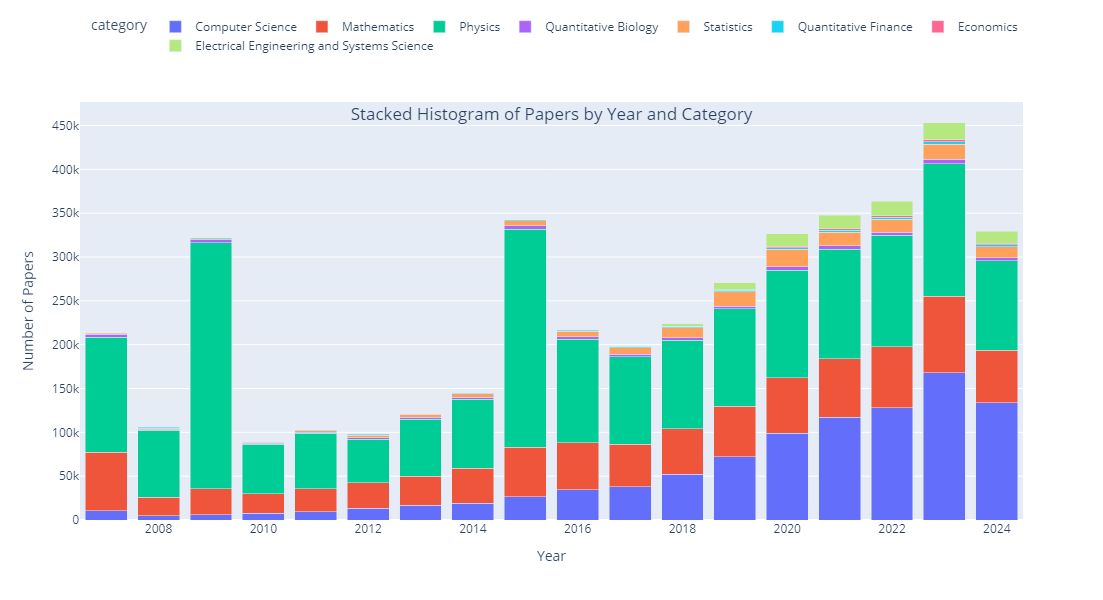

In [103]:
arxiv_metadata_plot = arxiv_metadata[['id', 'categories', 'year']]
arxiv_metadata_plot = arxiv_metadata_plot.assign(category=arxiv_metadata_plot['categories'].str.split(' ')).explode('category')
arxiv_metadata_plot['category'] = arxiv_metadata_plot['category'].apply(lambda x: get_category(x))

# Group by year and category, then count papers
arxiv_metadata_plot = arxiv_metadata_plot.groupby(['year', 'category']).size().reset_index(name='count')

# Plot stacked histogram using Plotly
fig = px.bar(arxiv_metadata_plot, x='year', y='count', color='category',
             title='Stacked Histogram of Papers by Year and Category',
             labels={'year': 'Year', 'count': 'Number of Papers'},
             barmode='stack')

fig.update_layout(
    width=550,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ),
    title=dict(
        y=0.82,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

save_and_show(fig, "category_research_per_year")

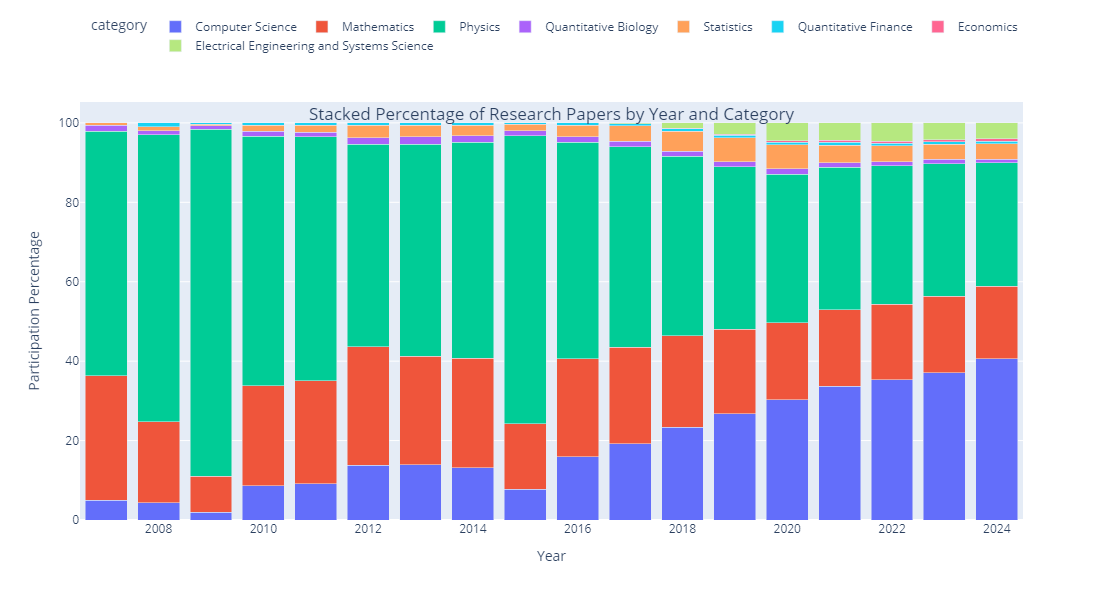

In [104]:
arxiv_metadata_plot = arxiv_metadata[['id', 'categories', 'year']]
arxiv_metadata_plot = arxiv_metadata_plot.assign(category=arxiv_metadata_plot['categories'].str.split(' ')).explode('category')
arxiv_metadata_plot['category'] = arxiv_metadata_plot['category'].apply(lambda x: get_category(x))

# Group by year and category, then count papers
arxiv_metadata_plot = arxiv_metadata_plot.groupby(['year', 'category']).size().reset_index(name='count')

# Plot stacked histogram using Plotly
# Calculate the total count per year for percentage calculation
total_per_year = arxiv_metadata_plot.groupby('year')['count'].sum().reset_index()
total_per_year.columns = ['year', 'total_count']

# Merge the total counts with the grouped data
arxiv_metadata_plot = pd.merge(arxiv_metadata_plot, total_per_year, on='year')

# Calculate the percentage
arxiv_metadata_plot['percentage'] = arxiv_metadata_plot['count'] / arxiv_metadata_plot['total_count'] * 100

# Plot stacked percentage plot using Plotly
fig = px.bar(arxiv_metadata_plot, x='year', y='percentage', color='category',
             title='Stacked Percentage of Research Papers by Year and Category',
             labels={'year': 'Year', 'percentage': 'Participation Percentage'},
             barmode='stack')

fig.update_layout(
    width=550,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ),
    title=dict(
        y=0.82,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

save_and_show(fig, "stacked_category_research_per_year")

In [105]:
arxiv_metadata_plot = arxiv_metadata[['id', 'categories', 'year']]
arxiv_metadata_plot = arxiv_metadata_plot.assign(category=arxiv_metadata_plot['categories'].str.split(' '))
arxiv_metadata_plot['category'] = arxiv_metadata_plot['category'].apply(lambda x: get_categories(x))

arxiv_metadata_plot.head()

# Create a DataFrame for the intersection
intersection_data = []
for i, cat1 in enumerate(all_main_categories):
    row = []
    for j, cat2 in enumerate(all_main_categories):
        if j >= i:
            count = 0
        else:
            count = sum(1 for cats in arxiv_metadata_plot['category'] if cat1 in cats and cat2 in cats)
        row.append(count)
    intersection_data.append(row)

arxiv_metadata_plot = pd.DataFrame(intersection_data, index=all_main_categories, columns=all_main_categories)

fig = go.Figure(data=go.Heatmap(
                    z=arxiv_metadata_plot.values,
                    x=arxiv_metadata_plot.columns,
                    y=arxiv_metadata_plot.index,
                    hoverongaps = False,
                    colorscale='Viridis'))

# Update layout
fig.update_layout(
    title='Main Category Co-occurrence Heatmap',
    xaxis_title='Categories',
    yaxis_title='Categories',
    width=800,
    height=800
)

# Add text annotations
annotations = []
for i, row in enumerate(arxiv_metadata_plot.values):
    for j, value in enumerate(row):
        annotations.append(
            dict(
                x=arxiv_metadata_plot.columns[j],
                y=arxiv_metadata_plot.index[i],
                text=str(value),
                showarrow=False,
                font=dict(color='white' if value > arxiv_metadata_plot.values.max() / 2 else 'black')
            )
        )
fig.update_layout(annotations=annotations)

# Show the plot
save_and_show(fig, "category_co_occurence")

#### Conclusions

1. The number of research papers generated has been growing, especially in the category of `Computer Science`. Other than that, `Physics` seem to be the most active area of research. Since 2022, papers in Computer Science has surpassed `Physics` in generating published research.
2. Computer Science and Mathematics have the most common papers, Physics and Mathematics being the second one.

## Computer Science

As we're specifically interested in Computer Science, we'll filter out papers and only look at papers in Computer Science and do a similar kind of analysis involving the sub-categories of computer science.

### Sub-fields of Computer Science

In [106]:
def get_cs_sub_category(category_id):
    global categories
    if not category_id.startswith('cs.'):
        return ""
    try:
        return categories[category_id]['Name']
    except KeyError as e:
        return ""


def get_cs_sub_categories(category_ids):
    category_ids = category_ids.split(' ')
    
    to_return = set([str(get_cs_sub_category(cid)) for cid in category_ids])
    return [a for a in to_return if len(a) > 0]

In [107]:
arxiv_metadata = arxiv_metadata.assign(main_categories=arxiv_metadata['categories'].str.split(' '))
arxiv_metadata['main_categories'] = arxiv_metadata['main_categories'].apply(lambda x: get_categories(x))

In [108]:
arxiv_metadata['is_cs'] = arxiv_metadata['main_categories'].apply(lambda x: 'Computer Science' in x)
cs_arxiv_metadata = arxiv_metadata[arxiv_metadata['is_cs']]
cs_arxiv_metadata['cs_categories'] = cs_arxiv_metadata['categories'].apply(lambda x: get_cs_sub_categories(x))

C:\Users\chira\AppData\Local\Temp\ipykernel_26416\429207710.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



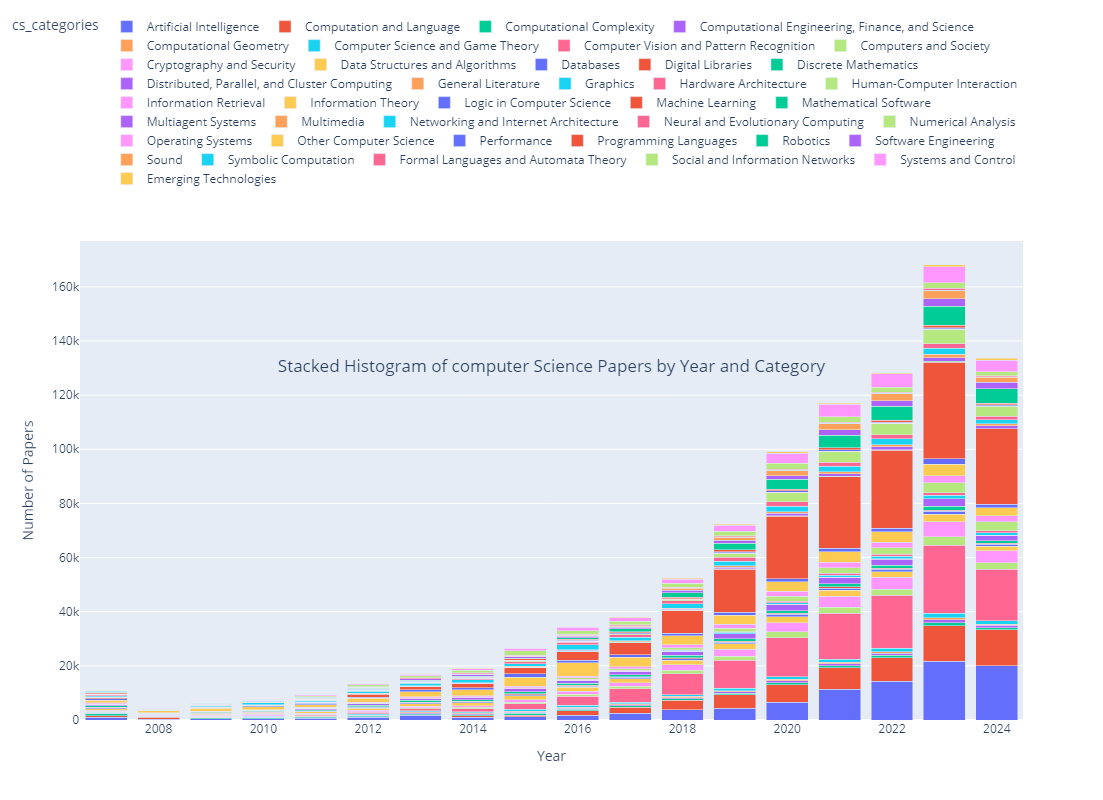

In [109]:
cs_arxiv_metadata_plot = cs_arxiv_metadata[['id', 'cs_categories', 'year']]
cs_arxiv_metadata_plot = cs_arxiv_metadata_plot.explode('cs_categories')

# Group by year and category, then count papers
cs_arxiv_metadata_plot = cs_arxiv_metadata_plot.groupby(['year', 'cs_categories']).size().reset_index(name='count')

# Plot stacked histogram using Plotly
fig = px.bar(cs_arxiv_metadata_plot, x='year', y='count', color='cs_categories',
             title='Stacked Histogram of computer Science Papers by Year and Category',
             labels={'year': 'Year', 'count': 'Number of Papers'},
             barmode='stack')

fig.update_layout(
    width=700,
    height=800,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ),
    title=dict(
        y=0.55,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

save_and_show(fig, "cs_research_per_year")

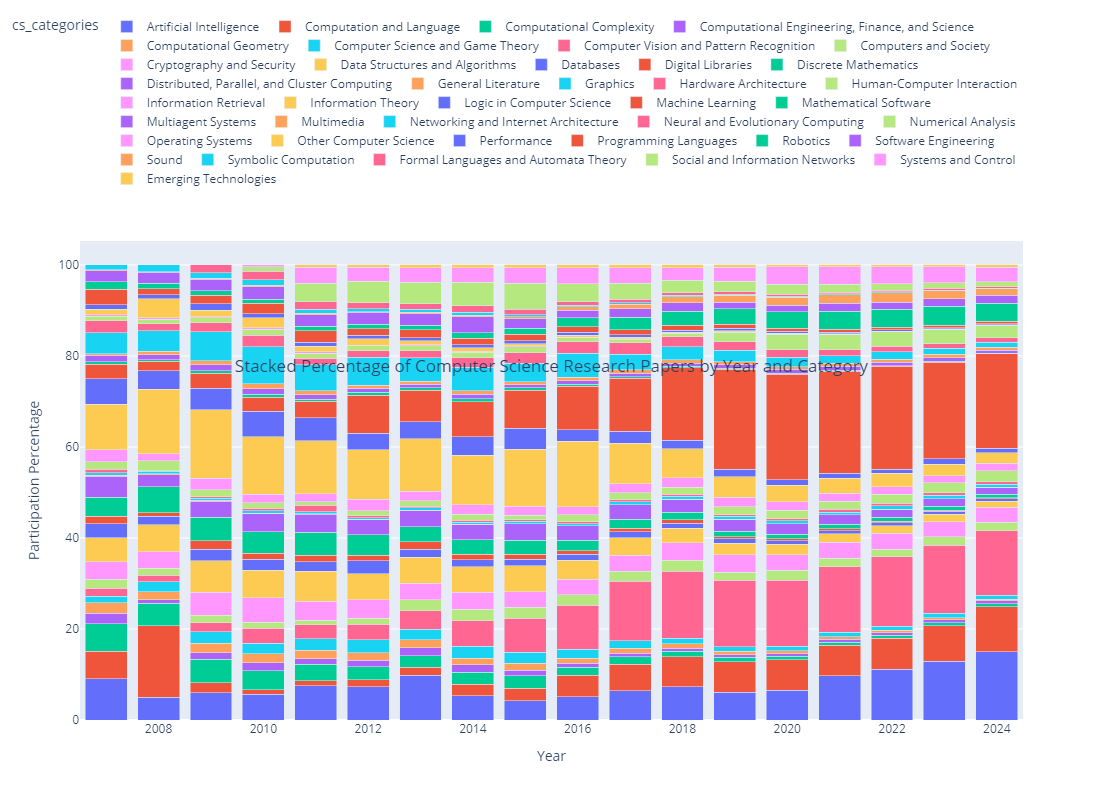

In [110]:
cs_arxiv_metadata_plot = cs_arxiv_metadata[['id', 'cs_categories', 'year']]
cs_arxiv_metadata_plot = cs_arxiv_metadata_plot.explode('cs_categories')

# Group by year and category, then count papers
cs_arxiv_metadata_plot = cs_arxiv_metadata_plot.groupby(['year', 'cs_categories']).size().reset_index(name='count')

# Plot stacked histogram using Plotly
# Calculate the total count per year for percentage calculation
total_per_year = cs_arxiv_metadata_plot.groupby('year')['count'].sum().reset_index()
total_per_year.columns = ['year', 'total_count']

# Merge the total counts with the grouped data
cs_arxiv_metadata_plot = pd.merge(cs_arxiv_metadata_plot, total_per_year, on='year')

# Calculate the percentage
cs_arxiv_metadata_plot['percentage'] = cs_arxiv_metadata_plot['count'] / cs_arxiv_metadata_plot['total_count'] * 100

# Plot stacked percentage plot using Plotly
fig = px.bar(cs_arxiv_metadata_plot, x='year', y='percentage', color='cs_categories',
             title='Stacked Percentage of Computer Science Research Papers by Year and Category',
             labels={'year': 'Year', 'percentage': 'Participation Percentage'},
             barmode='stack')

fig.update_layout(
    width=700,
    height=800,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ),
    title=dict(
        y=0.55,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

save_and_show(fig, "stacked_cs_research_per_year")

### Top 5 fields in Computer Science

We'll check the top areas in the last few years, while variying the period. 

In [111]:
categories_df[categories_df['Main Category'] == 'Computer Science']

,ID,Main Category,Name,Description
0,cs.AI,Computer Science,Artificial Intelligence,"Covers all areas of AI except Vision, Robotics..."
1,cs.AR,Computer Science,Hardware Architecture,Covers systems organization and hardware archi...
2,cs.CC,Computer Science,Computational Complexity,"Covers models of computation, complexity class..."
3,cs.CE,Computer Science,"Computational Engineering, Finance, and Science",Covers applications of computer science to the...
4,cs.CG,Computer Science,Computational Geometry,Roughly includes material in ACM Subject Class...
5,cs.CL,Computer Science,Computation and Language,Covers natural language processing. Roughly in...
6,cs.CR,Computer Science,Cryptography and Security,Covers all areas of cryptography and security ...
7,cs.CV,Computer Science,Computer Vision and Pattern Recognition,"Covers image processing, computer vision, patt..."
8,cs.CY,Computer Science,Computers and Society,"Covers impact of computers on society, compute..."
9,cs.DB,Computer Science,Databases,"Covers database management, datamining, and da..."


In [112]:
def get_top_n_fields(data, year_end, year_start=2006, top_n=5):
    filtered_df = data[(data['year'] <= year_end) & (data['year'] >= year_start)]
    
    # Group by cs_categories and sum the count
    grouped_df = filtered_df.groupby('cs_categories')['count'].sum().reset_index()
    
    # Sort the grouped DataFrame by count in descending order and select the top 3 categories
    top_categories = grouped_df.sort_values(by='count', ascending=False).head(top_n)
    top_categories = top_categories.merge(categories_df[categories_df['Main Category'] == 'Computer Science'], left_on='cs_categories', right_on='Name')
    top_categories = top_categories[['Name', 'count', 'Description']]
    return top_categories

In [113]:
top_n = 5
year_end = 2010
top_fields = get_top_n_fields(cs_arxiv_metadata_plot, year_end, top_n=top_n)

print(f"The top {top_n} cs_categories till {year_end}: {sum(top_fields['count'])}")
with pd.option_context('display.max_colwidth', None):
    display(top_fields)

The top 5 cs_categories till 2010: 10648


,Name,count,Description
0,Information Theory,3633,Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.
1,Artificial Intelligence,2006,"Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11."
2,Data Structures and Algorithms,1723,"Covers data structures and analysis of algorithms. Roughly includes material in ACM Subject Classes E.1, E.2, F.2.1, and F.2.2."
3,Networking and Internet Architecture,1716,"Covers all aspects of computer communication networks, including network architecture and design, network protocols, and internetwork standards (like TCP/IP). Also includes topics, such as web caching, that are directly relevant to Internet architecture and performance. Roughly includes all of ACM Subject Class C.2 except C.2.4, which is more likely to have Distributed, Parallel, and Cluster Computing as the primary subject area."
4,Computation and Language,1570,"Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area."


In [114]:
top_n = 5
year_end = 2015
top_fields = get_top_n_fields(cs_arxiv_metadata_plot, year_end, top_n=top_n)

print(f"The top {top_n} cs_categories till {year_end}: {sum(top_fields['count'])}")
with pd.option_context('display.max_colwidth', None):
    display(top_fields)

The top 5 cs_categories till 2015: 40836


,Name,count,Description
0,Information Theory,13522,Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.
1,Artificial Intelligence,7496,"Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11."
2,Machine Learning,7167,"Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods."
3,Data Structures and Algorithms,6643,"Covers data structures and analysis of algorithms. Roughly includes material in ACM Subject Classes E.1, E.2, F.2.1, and F.2.2."
4,Networking and Internet Architecture,6008,"Covers all aspects of computer communication networks, including network architecture and design, network protocols, and internetwork standards (like TCP/IP). Also includes topics, such as web caching, that are directly relevant to Internet architecture and performance. Roughly includes all of ACM Subject Class C.2 except C.2.4, which is more likely to have Distributed, Parallel, and Cluster Computing as the primary subject area."


In [115]:
top_n = 5
year_end = 2020
top_fields = get_top_n_fields(cs_arxiv_metadata_plot, year_end, top_n=top_n)

print(f"The top {top_n} cs_categories till {year_end}: {sum(top_fields['count'])}")
with pd.option_context('display.max_colwidth', None):
    display(top_fields)

The top 5 cs_categories till 2020: 188808


,Name,count,Description
0,Machine Learning,62166,"Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods."
1,Computer Vision and Pattern Recognition,45971,"Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5."
2,Information Theory,32090,Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.
3,Artificial Intelligence,26454,"Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11."
4,Computation and Language,22127,"Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area."


In [116]:
top_n = 5
year_end = 2024
top_fields = get_top_n_fields(cs_arxiv_metadata_plot, year_end, top_n=top_n)

print(f"The top {top_n} cs_categories till {year_end}: {sum(top_fields['count'])}")
with pd.option_context('display.max_colwidth', None):
    display(top_fields)

The top 5 cs_categories till 2024: 513248


,Name,count,Description
0,Machine Learning,180770,"Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods."
1,Computer Vision and Pattern Recognition,126555,"Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5."
2,Artificial Intelligence,93756,"Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11."
3,Computation and Language,65216,"Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area."
4,Information Theory,46951,Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.


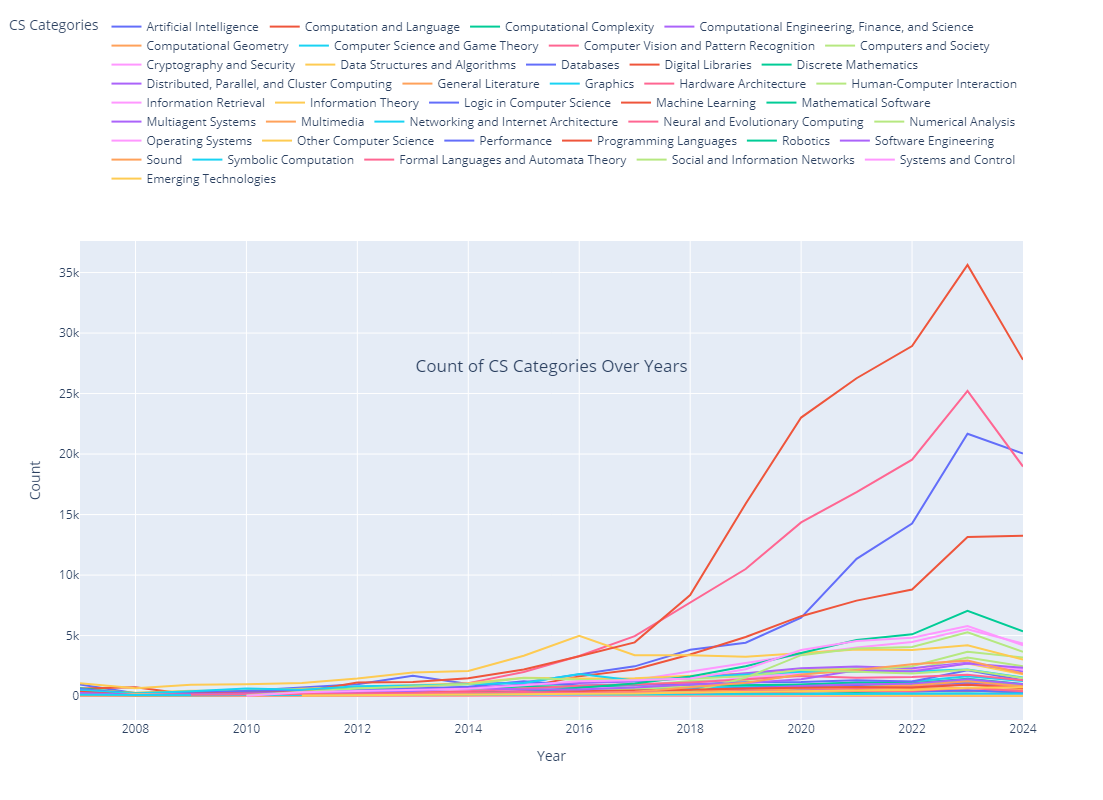

In [118]:
# Create the line plot using Plotly
fig = px.line(cs_arxiv_metadata_plot, x='year', y='count', color='cs_categories', 
              title='Count of CS Categories Over Years',
              labels={'year': 'Year', 'count': 'Count', 'cs_categories': 'CS Categories'})

fig.update_layout(
    width=700,
    height=800,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ),
    title=dict(
        y=0.55,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

# Show the plot
save_and_show(fig, "cs_categories_per_year_line")

We're literally having a **Renaissance** period in **Artificial Intelligence** through `Machine Learning`. Even though the categories, machine learning, Computer vision and pattern recognition, and artificial intelligence, Computation and Language might be separate fields as shown here, they are cut from the same cloth and basically have the aim of installing _intelligence_ in machines. There's just an immense amount of research being done and published in this area.

### Hottest topics in the Top Computer Science Fields
Let's look at the top fields and see what are the hottest topics in those areas in the past 5 years. The top fields we'll consider:
1. Machine Learning
2. Computer Vision and Pattern Recognition
3. Artificial Intelligence
4. Computation and Language
5. Information Theory

But, how do we go about doing that? We only have information till the sub-category. We can use the abstract information to start with and try out advance techniques later on

In [119]:
top_fields = top_fields['Name'].tolist()

In [120]:
cs_arxiv_metadata_exploded = cs_arxiv_metadata.explode('cs_categories')
cs_arxiv_metadata_top = cs_arxiv_metadata_exploded[cs_arxiv_metadata_exploded['cs_categories'].isin(top_fields)]

In [121]:
cs_arxiv_metadata_abstracts = " ".join(cs_arxiv_metadata_top['abstract'].tolist())

In [122]:
custom_stopwords = ['propose', 'problem', 'using', 'show', 'introduce', 'new', 'approach', 'technique', 'method', 'result', 'performance', 'present', 'paper']
stop_words = set(stopwords.words('english') + custom_stopwords)

translator = str.maketrans('', '', string.punctuation)
cleaned_text = " ".join([word for word in cs_arxiv_metadata_abstracts.translate(translator).split() if word.lower() not in stop_words])

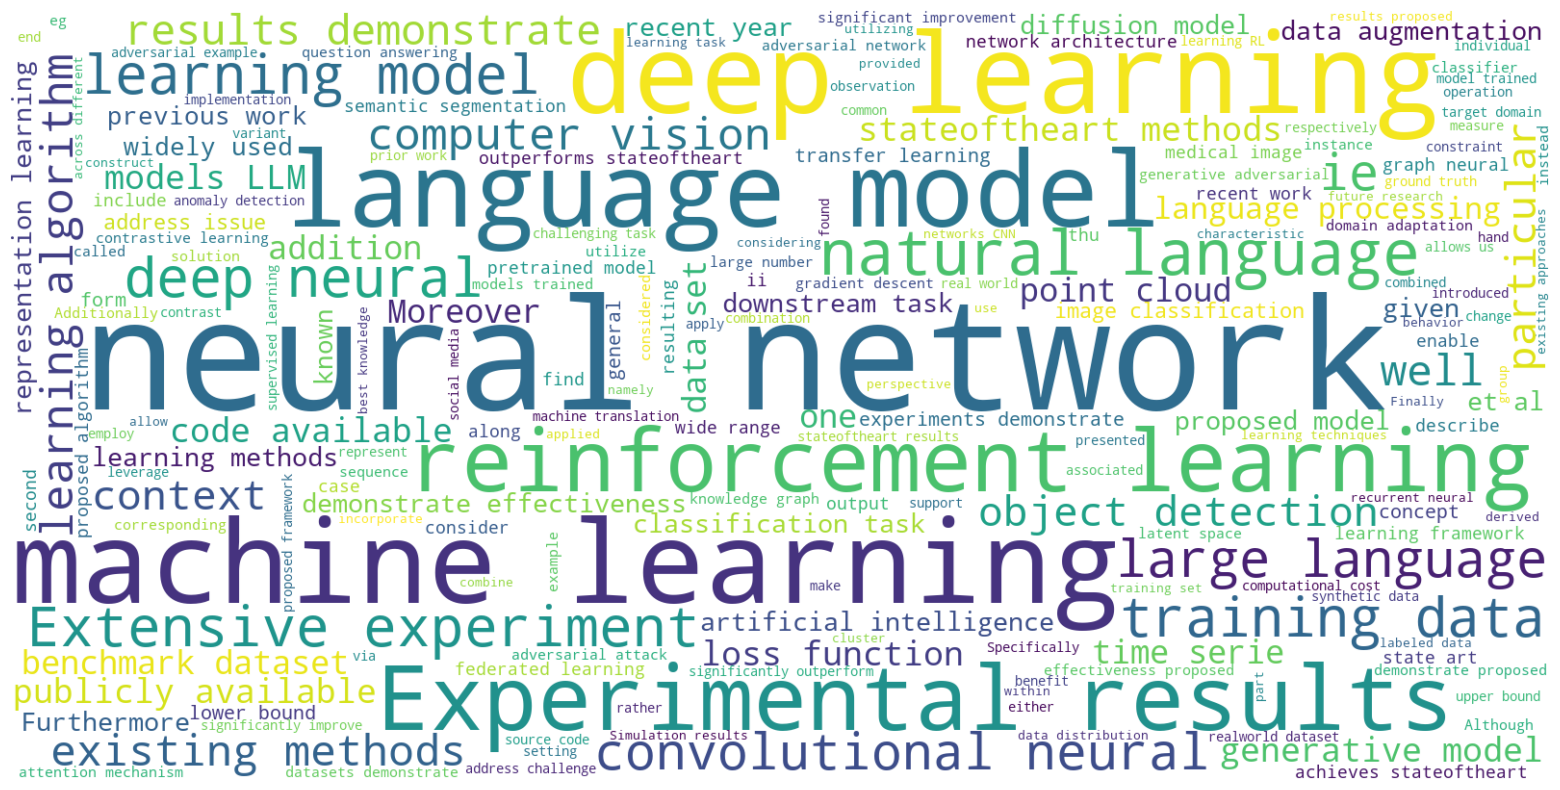

In [123]:
# Generate the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=200).generate(cleaned_text)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('./graphs/wordcloud.png', bbox_inches='tight')
plt.show()

Funnily, `Experimental results` is such a common word. Shows, most papers have been developed by experimentation and lesser theoritical results have been published. The common themes that jump out:
1. machine learning (encompassing neural networks)
2. neural network / deep learning (study of neural networks)
3. convolutional neural networks (Type of neural network)
4. large language model (Type of neural network created via Transformers / attention mechanism)
5. reinforcement learning (method of training machine learning algorithms)